In [1]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
files_dir = 'D:/PROJECTS/MiniProject/New folder/'

class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.png']
        # print(self.imgs)
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'number_plate']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(1)
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)
dataset = FruitImagesDataset(files_dir, 256, 256)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print(img.shape, '\n',target)

length of dataset =  433 

(256, 256, 3) 
 {'boxes': tensor([[ 72.9600, 101.1200, 146.5600, 129.2800]]), 'labels': tensor([1]), 'area': tensor([2072.5757]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


[[[0.6301317  0.72598445 0.8004447 ]
  [0.6306219  0.7207706  0.7953386 ]
  [0.64293045 0.72691745 0.8037837 ]
  ...
  [0.5878626  0.7015601  0.7901501 ]
  [0.5855409  0.6960049  0.7855409 ]
  [0.5809855  0.6946916  0.78098553]]

 [[0.62242645 0.71936274 0.79105395]
  [0.62291664 0.7104167  0.7882353 ]
  [0.6313726  0.7176471  0.79607844]
  ...
  [0.5666207  0.6790439  0.7668275 ]
  [0.5717618  0.68511367 0.7717618 ]
  [0.5800506  0.6929381  0.7801992 ]]

 [[0.62286806 0.71995515 0.7916463 ]
  [0.623606   0.7110522  0.78857994]
  [0.6320619  0.7183364  0.7964231 ]
  ...
  [0.5579525  0.6762889  0.7622188 ]
  [0.56655943 0.6845512  0.76724875]
  [0.5806526  0.69889206 0.78391284]]

 ...

 [[0.24195006 0.26805037 0.20716648]
  [0.14057282 0.15748459 0.11849126]
  [0.03715748 0.04121907 0.02948285]
  ...
  [0.11162061 0.13012001 0.09008598]
  [0.14306018 0.15421215 0.10240503]
  [0.08633531 0.09135982 0.08303175]]

 [[0.1821404  0.2010589  0.16338871]
  [0.19395106 0.20656762 0.16426285]


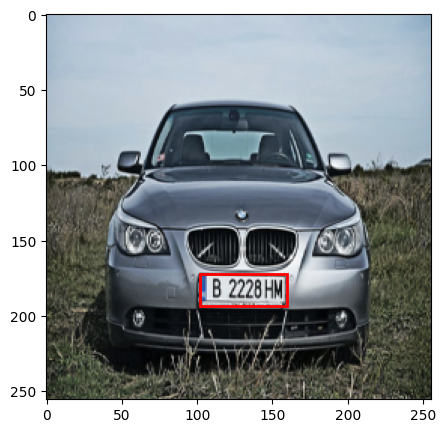

In [3]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    print(type(img))
    a.imshow(img)
    for box in (target):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
print(img)
plot_img_bbox(img, target['boxes'])

In [19]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, quantize=True)
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, quantize=True)
    # model = torchvision.models.quantization.resnet50(pretrained=True, quantize=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [20]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [21]:
dataset = FruitImagesDataset(files_dir, 256, 256, transforms= get_transform(train=False))
# dataset_test = FruitImagesDataset(files_dir, 256, 256, transforms= get_transform(train=False))

In [22]:
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
print(torch.cuda.is_available())

num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

cuda
True


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to C:\Users\subra/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:05<00:00, 14.9MB/s]


In [24]:
print(torch.cuda.is_available())
torch.zeros(1).cuda()

True


tensor([0.], device='cuda:0')

In [25]:
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    try:
        evaluate(model, data_loader_test, device=device)
    except IndexError as e:
        print(f"Error occurred during evaluation: {e}")
        continue

Epoch: [0]  [ 0/35]  eta: 0:01:15  lr: 0.000152  loss: 0.8791 (0.8791)  loss_classifier: 0.6864 (0.6864)  loss_box_reg: 0.0456 (0.0456)  loss_objectness: 0.1382 (0.1382)  loss_rpn_box_reg: 0.0090 (0.0090)  time: 2.1477  data: 0.7916  max mem: 550
Epoch: [0]  [10/35]  eta: 0:00:18  lr: 0.001621  loss: 0.5699 (0.6193)  loss_classifier: 0.4323 (0.4288)  loss_box_reg: 0.0356 (0.0385)  loss_objectness: 0.1382 (0.1432)  loss_rpn_box_reg: 0.0076 (0.0088)  time: 0.7349  data: 0.3445  max mem: 679
Epoch: [0]  [20/35]  eta: 0:00:10  lr: 0.003090  loss: 0.3543 (0.4668)  loss_classifier: 0.1680 (0.2928)  loss_box_reg: 0.0356 (0.0530)  loss_objectness: 0.1036 (0.1119)  loss_rpn_box_reg: 0.0076 (0.0091)  time: 0.6232  data: 0.3281  max mem: 679
Epoch: [0]  [30/35]  eta: 0:00:03  lr: 0.004559  loss: 0.2403 (0.4038)  loss_classifier: 0.1054 (0.2379)  loss_box_reg: 0.0815 (0.0686)  loss_objectness: 0.0464 (0.0890)  loss_rpn_box_reg: 0.0060 (0.0083)  time: 0.6465  data: 0.3418  max mem: 687
Epoch: [0]  

In [26]:
torch.save(model, 'Faster-RCNN-mobilenetv3.pth')

In [27]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [29]:
# Load the entire model
loaded_model = torch.load('./Faster-RCNN-mobilenetv3.pth')

In [30]:
test = "D:/PROJECTS/FasterRCNN/test1.jpeg"


In [31]:
img, target = dataset[14]
# print(target)
# put the model in evaluation mode

loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  1
real #boxes:  1


EXPECTED OUTPUT
<class 'torch.Tensor'>
<class 'PIL.Image.Image'>


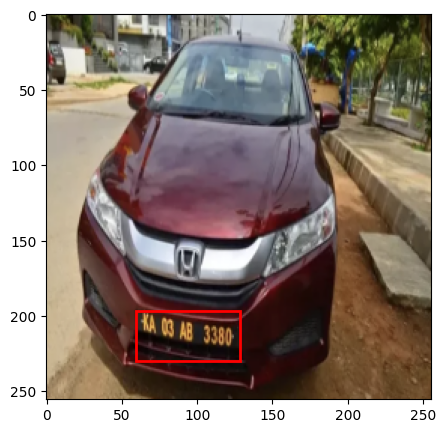

In [32]:
print('EXPECTED OUTPUT')
print(type(img))
# print(target)
plot_img_bbox(torch_to_pil(img), target['boxes'])

MODEL OUTPUT
<class 'PIL.Image.Image'>


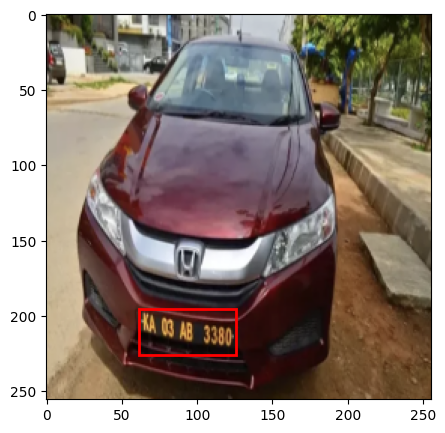

In [33]:

print('MODEL OUTPUT')
# print(prediction)
tensor_array = prediction['boxes'].cpu()
# print(numpy_array)
plot_img_bbox(torch_to_pil(img), tensor_array)

NMS APPLIED MODEL OUTPUT
<class 'PIL.Image.Image'>


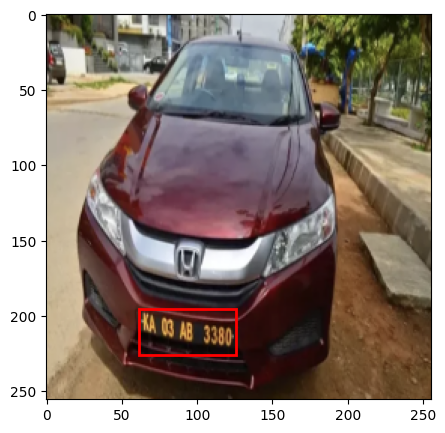

[[[0.2901961  0.28357843 0.25355393 ... 0.13259804 0.13933824 0.12377451]
  [0.29388785 0.29038516 0.23982508 ... 0.14528857 0.12318666 0.12804314]
  [0.29411766 0.2937945  0.2537885  ... 0.13336158 0.11676288 0.13947754]
  ...
  [0.6427548  0.634241   0.5999239  ... 0.42757353 0.4023562  0.38041943]
  [0.53711367 0.59895116 0.6195327  ... 0.42683393 0.41061103 0.41151577]
  [0.6431373  0.6431373  0.6911765  ... 0.41495097 0.4117647  0.39767158]]

 [[0.27561274 0.27181372 0.24889706 ... 0.08786765 0.09289216 0.07781862]
  [0.27561274 0.27804363 0.23516822 ... 0.10055817 0.07927869 0.08370242]
  [0.27915135 0.28196996 0.24703059 ... 0.09073223 0.0735658  0.09623258]
  ...
  [0.5371477  0.5253729  0.49404153 ... 0.2935049  0.2726213  0.25100768]
  [0.4338848  0.4930688  0.51365036 ... 0.2927653  0.27762476 0.28164446]
  [0.5372549  0.5372549  0.5852941  ... 0.28088236 0.27450982 0.26041666]]

 [[0.22352941 0.20367648 0.15465686 ... 0.02267157 0.05367647 0.03860294]
  [0.22618288 0.206791

In [34]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
tensor_array = nms_prediction['boxes'].cpu()
plot_img_bbox(torch_to_pil(img), tensor_array)
print(img.numpy())

(256, 256, 3)
61.201477 195.37439 125.538574 226.07576
Yom tn



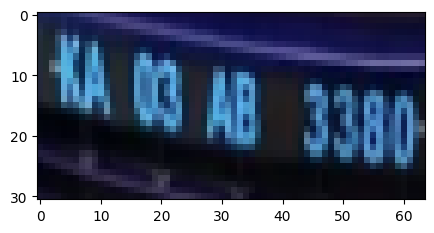

In [35]:
import pytesseract
# print(type(img))
# print(img.numpy())
smaple_image = cv2.imread(test)
# print(smaple_image)
numpy_image = img.cpu().numpy()

# Rescale to 0-255
# print(numpy_image)
numpy_image = (numpy_image * 255).astype(np.uint8)

# Transpose the image if needed (channels, height, width) -> (height, width, channels)
numpy_image = np.transpose(numpy_image, (1, 2, 0))

# Convert to RGB
rgb_image = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB)
print(rgb_image.shape)
roi = tensor_array.numpy()
for i in roi:
    x, y, w, h = i
    print(x,y,w,h)
    img_array = img.numpy()
    # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print(img_rgb)
    plate = rgb_image[int(y):int(h), int(x):int(w)]
    # print(plate)
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    # print(type(img))
    a.imshow(plate)
    text = pytesseract.image_to_string(plate, config='--psm 8')
    print(text)
    # break

